In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 14

In [3]:
import pandas as pd 
import dataprep.dataset as dp
filename='310_11_more_params.csv'#final_310_311_data.csv'
nsteps=250000
df = dp.load_reformated_cvs('../data/'+filename,nrows=nsteps)
df['B:VIMIN'] = df['B:VIMIN'].shift(-1)
#df['B:VIMIN_STD'] = df['B:VIMIN'].rolling(window=15).std()
#df['B:IMINER_STD'] = df['B:IMINER'].rolling(window=15).std()
df = df.set_index(pd.to_datetime(df.time))
df = df.dropna()
df = df.drop_duplicates()
print(len(df))
print(df.keys())

249999
Index(['time', 'file', 'I:IB', 'I:MDAT40', 'I:MXIB', 'B:LINFRQ', 'B:VIMIN',
       'B:IMINER', 'B:VIMAX', 'B:VIPHAS'],
      dtype='object')


In [4]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, RobustScaler

## 1 second (cycle - 15Hz)
look_back    = 10*15 
look_forward = 1 
    
def create_dataset(dataset, look_back=1,look_forward=1):
    X, Y = [], []
    offset = look_back+look_forward
    for i in range(len(dataset)-(offset+1)):
        xx = dataset[i:(i+look_back), 0]
        yy = dataset[(i + look_back):(i + offset), 0]
        X.append(xx)
        Y.append(yy)
    return np.array(X), np.array(Y)

def get_dataset(variable='B:VIMIN'):

    dataset = df[variable].values #numpy.ndarray
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0.0001, 1))
    #scaler = RobustScaler()
    dataset = scaler.fit_transform(dataset)

    ## TODO: Fix
    #print(len(dataset))
    train_size = int(len(dataset) * 0.70)
    #print(train_size)
    test_size = len(dataset) - train_size
    #print(test_size)

    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    X_train, Y_train = create_dataset(train, look_back,look_forward)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
    #print(X_train.shape)
    #print(Y_train.shape)
    
    X_test, Y_test = create_dataset(test, look_back,look_forward)
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    Y_test = np.reshape(Y_test, (Y_test.shape[0],  Y_test.shape[1]))
    #print(X_test.shape)
    #print(Y_test.shape)
    return scaler, X_train, Y_train, X_test, Y_test

variables = ['B:VIMIN','B:IMINER','B:VIPHAS','B:LINFRQ','I:IB','I:MDAT40','I:MXIB']
data_list = []
x_train_list = []
x_test_list = []
for v in range(len(variables)):
    data_list.append(get_dataset(variable=variables[v]))
    x_train_list.append(data_list[v][1])
    x_test_list.append(data_list[v][3])
    
# Axis
concate_axis=1


## Booster model data
BoX_train = np.concatenate(x_train_list,axis=concate_axis) 
BoY_train = np.concatenate((data_list[0][2],data_list[1][2]),axis=1) 
BoX_test = np.concatenate(x_test_list,axis=concate_axis) 
BoY_test = np.concatenate((data_list[0][4],data_list[1][4]),axis=1) 

print(BoX_train.shape)
print(BoY_train.shape)
#from pickle import dump
# save the scaler
#for v in range(len(variables)):
#    dump(data_list[v][0], open('t0_mmscaker_var{}_nsteps{}k_simple.pkl'.format(v,int(nsteps/1000)), 'wb'))

(174847, 7, 150)
(174847, 2)


In [5]:
import time
from datetime import datetime
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import tensorflow as tf

import src.analysis as ana
import src.models as models
e=250
bs=99
in_shape=(len(variables),150)
if concate_axis==2:
    in_shape=(1,len(variables)*150)
    
start_time=time.time()
now = datetime.now()
timestamp = now.strftime("D%m%d%Y-T%H%M%S")
print("date and time:", timestamp)
##
save_name='fullbooster_e{}_bs{}_nsteps{}k_nvar{}_axis{}_mmscaler_t0_{}'.format(e,bs,int(nsteps/1000),len(variables),concate_axis,timestamp)

## Callbacks
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.85, patience=5, min_lr=1e-6,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=1, mode='auto',
                               baseline=None, restore_best_weights=False)

## Model 
booster_model = models.build_lstm_model(input_shape=in_shape,output_shape=2)
opt = Adam(lr=1e-2,clipnorm=1.0, clipvalue=0.5)
#booster_model.compile(loss='mean_squared_error', optimizer=opt,metrics=['mape','mae'])
booster_model.compile(loss='mse', optimizer=opt,metrics=['mse','mape','mae'])
booster_model.summary()

## Run multiple versions 
histories = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)
k=0
for train_index, val_index in kf.split(BoX_train):
    ## Prep data
    x_train, x_val = BoX_train[train_index], BoX_train[val_index]
    y_train, y_val = BoY_train[train_index], BoY_train[val_index]
    print('########################')
    print('### Running {} split. ###'.format(k))
    print('### TrainX shape {}  ###'.format(x_train.shape))
    print('### TrainY shape {}  ###'.format(y_train.shape))
    print('### ValX shape {}  ###'.format(x_val.shape))
    print('### ValY shape {}  ###'.format(y_val.shape))
    print('########################')
    ## Save best model callback
    mcp_name=save_name+'_ksplit{}_'.format(k)
    mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath='models/'+mcp_name+'_e{epoch:02d}_vl{val_loss:.2f}.h5')
    ## Run model
    history = booster_model.fit(x_train, y_train, epochs=e, batch_size=bs, validation_data=(x_val,y_val),
                        callbacks=[reduce_lr,early_stopping,mcp_save], verbose=2, shuffle=True)
    histories.append(history)
    k+=1
    print('Current training time: {}'.format(time.time()-start_time))
    
print('Total training time: {}'.format(time.time()-start_time))
booster_model.save('models/'+mcp_name+'_final.h5')

date and time: D10062020-T142555
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            416768    
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 1,467,906
Trainable params: 1,467,906
Non-trainable params: 0
_________________________________________________________________
########################
### Running 0 split. ###
### TrainX shape (139877, 7, 150)  ###
### TrainY shape (139877, 2)  ###
### ValX shape (34970, 7, 150)  ###
### ValY shape (34970, 2)  ###
#####################

In [6]:
print(booster_model.metrics_names)
scores = booster_model.evaluate(BoX_test, BoY_test, verbose=1)
print(scores)

['loss', 'mse', 'mape', 'mae']
2339/2339 [==============================] - 10s 4ms/step - loss: 6.6277e-04 - mse: 6.2926e-04 - mape: 3.9029 - mae: 0.0132
[0.0006627677357755601, 0.0006292625330388546, 3.9028918743133545, 0.013223097659647465]


In [7]:
print(BoX_test.shape)
print(BoY_test.shape)

(74848, 7, 150)
(74848, 2)


(5000, 2)


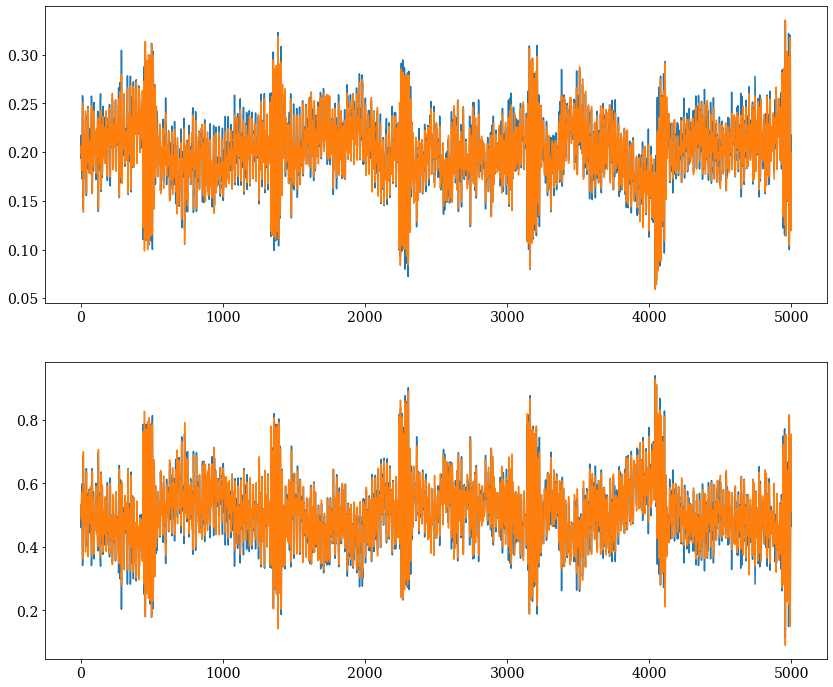

In [8]:
# loss_trace = []
# vloss_trace = []
# for k in range(5):
#     loss_trace.append(np.array(histories[k].history['loss']))
#     vloss_trace.append(np.array(histories[k].history['val_loss']))
# print(np.array(loss_trace).flatten())
# plt.figure(figsize=(12,10))
# plt.plot(np.array(loss_trace).flatten(), label='loss')
# plt.plot(np.array(vloss_trace).flatten(), label='val_loss')
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epochs')
# plt.legend(loc='upper right')
# plt.yscale('log')
# plt.savefig('{}.png'.format('models/loss_{}'.format(save_name)))

ana.plot_test(booster_model,BoX_test,BoY_test,nvar=2,name='models/test_{}'.format(save_name),start=0,end=5000)

(1000, 2)
(1000,)
(1000, 1)
(1000,)
mape ave:0.00526508130133152
(1000,)
(1000, 1)
(1000,)
mape ave:-138.41390991210938


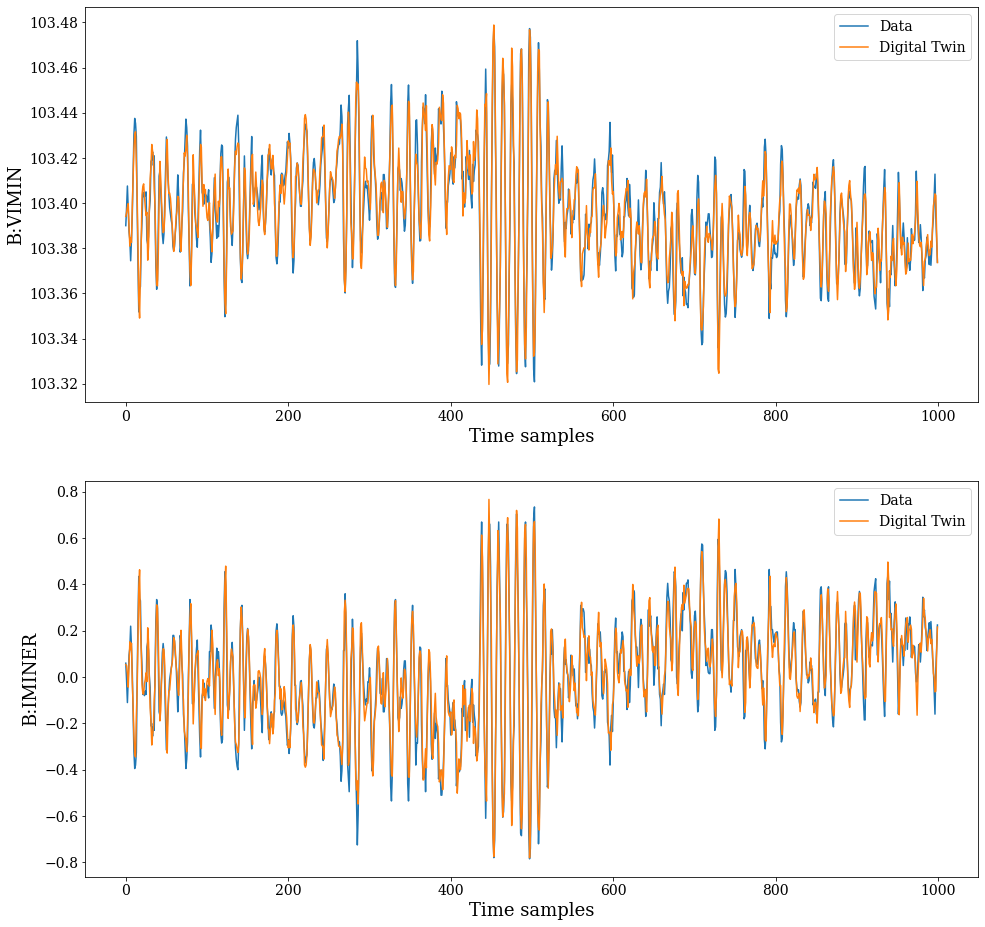

In [22]:
import seaborn as sns
model=booster_model
x_test=BoX_test
y_test=BoY_test
nvar=2
name='test_diff'
start=0
end=1000
x = np.linspace(start,end,int(end-start))
Y_predict = model.predict(x_test[start:end,:,:])
print(Y_predict.shape)
fig, axs = plt.subplots(nvar,figsize=(16,16))
for v in range (nvar):
    Y_test_var1 = data_list[v][0].inverse_transform(y_test[start:end,v].reshape(-1,1))
    Y_predict_var1 = data_list[v][0].inverse_transform(Y_predict[:,v].reshape(-1,1))
    #axs[v].plot(Y_test_var1,Y_predict_var1,'o')
    mape = 100*abs(Y_test_var1-Y_predict_var1)/Y_test_var1
    print(x.shape)
    print(mape.shape)
    mape = mape.reshape(-1,)
    print(mape.shape)
    print('mape ave:{}'.format(mape.mean()))
    axs[v].plot(Y_test_var1,label='Data')
    axs[v].plot(Y_predict_var1, label='Digital Twin')
    #axs[v].fill_between(x, mape, -mape, color='red',edgecolor="black",alpha=0.5) 
    #axs[v].plot(mape)
    #axs[v].set_title(variables[v])
    axs[v].set_ylabel(variables[v])
    axs[v].set_xlabel('Time samples')
    axs[v].legend()
plt.savefig('models/'+mcp_name+'_prediction_final.png')

# plt.savefig('{}.png'.format(name))

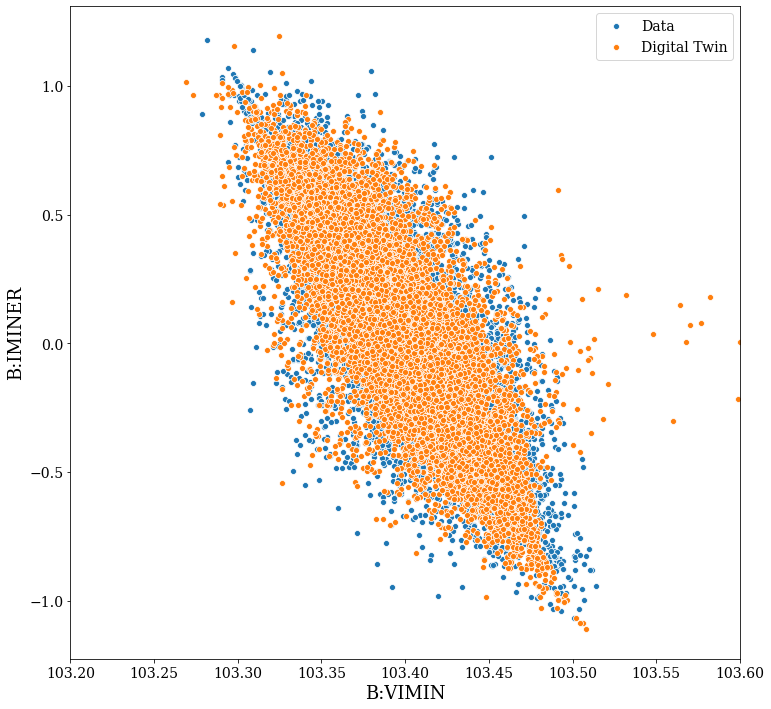

In [27]:
fig, axs = plt.subplots(1,figsize=(12,12))
x_test=BoX_test
y_test=BoY_test
start=0
end=BoX_test.shape[0]
Y_predict = model.predict(x_test[start:end,:,:])
Y_test_var0 = data_list[0][0].inverse_transform(y_test[start:end,0].reshape(-1,1)).reshape(-1,1)
Y_test_var1 = data_list[1][0].inverse_transform(y_test[start:end,1].reshape(-1,1)).reshape(-1,1)
Y_predict_var0 = data_list[0][0].inverse_transform(Y_predict[:,0].reshape(-1,1)).reshape(-1,1)
Y_predict_var1 = data_list[1][0].inverse_transform(Y_predict[:,1].reshape(-1,1)).reshape(-1,1)
np_predict = np.concatenate((Y_test_var0,Y_test_var1,Y_predict_var0,Y_predict_var1),axis=concate_axis) 
df_cool = pd.DataFrame(np_predict,columns=['data_va0','data_va1','pred_va0','pred_va1'])
#sns.pairplot(df_predict)
#np_data = np.concatenate((Y_predict_var0,Y_predict_var1),axis=concate_axis) 
#df_data = pd.DataFrame(np_data)
#sns.pairplot(df_data)
sns.scatterplot(data=df_cool, x="data_va0", y="data_va1", label='Data')#, hue="time")
sns.scatterplot(data=df_cool, x="pred_va0", y="pred_va1", label='Digital Twin')#, hue="time")

#axs.plot(Y_test_var0,Y_test_var1,'o', label='Data')
#axs.plot(Y_predict_var0,Y_predict_var1,'*', label='Digital Twin')
axs.set_xlabel('B:VIMIN')
axs.set_ylabel('B:IMINER')
axs.set_xlim(103.2,103.6)
plt.savefig('models/'+mcp_name+'_corr_final.png')
#plt.legend()

In [11]:
## 250 gives good results ##

In [14]:
booster_model.save('models/'+mcp_name+'_final.h5')